Isolated pixels, small islands and boundary pixels are removed;
Use spherical K-means

In [1]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import sys, os, time
import fitsio
import healpy as hp
from sklearn import cluster
from spherecluster import SphericalKMeans
sys.path.append('/Users/roz18/git/pixel_partition')
import pp_modules

In [2]:
# Parameters
min_neighbors = 7
min_island_size = 100
n_clusters = 100

In [3]:
# Random catalog
randoms = fitsio.read('/Users/roz18/Documents/Data/decals_randoms/dr5.0/randoms/dr5.0_2v_5000_starmasked.fits')

In [4]:
# Remove regions masked out in DECaLS
ra_centers = [229.62, 228.88, 237.8]
dec_centers = [2.16, 0.5, 4.5]
mask_randoms = np.zeros(len(randoms), dtype=bool)
for index in range(len(ra_centers)):
    ra_center, dec_center = ra_centers[index], dec_centers[index]
    mask_randoms |= (randoms['ra']>ra_center-0.2) & (randoms['ra']<ra_center+0.2) \
             & (randoms['dec']>dec_center-0.25) & (randoms['dec']<dec_center+0.25)
randoms = randoms[~mask_randoms]
print(len(randoms))

# Remove regions outside the bright star mask
ramin =  [0,     47,  115,  110,  135,  100,  320,  310, 300]
ramax =  [360,  100,  120,  114,  155,  300,  330,  330, 317]
decmin = [-90,  -90, -1.7,   17,   -4,  -90,   10,   10, -90]
decmax = [-7.5,  90,  1.2,  20,  -2.4,   -3,   12,   22, 90]
tilted_cut_ra, tilted_cut_dec = [240, 263], [0, 27]
mask = np.zeros(len(randoms), dtype=bool)
for index in range(len(ramin)):
    mask |= (randoms['ra']>ramin[index]) & (randoms['ra']<ramax[index]) & \
            (randoms['dec']>decmin[index]) & (randoms['dec']<decmax[index])
mask1 = randoms['dec']<(tilted_cut_dec[0] + (tilted_cut_dec[1]-tilted_cut_dec[0])/(tilted_cut_ra[1]-tilted_cut_ra[0])*(randoms['ra']-tilted_cut_ra[0]))
mask1 &= randoms['ra']<300
mask |= mask1
randoms = randoms[~mask]
print(len(randoms))

# Remove objects masked by the eBOSS LRG bright star mask
mask = randoms['star_contam']!=True
randoms = randoms[mask]
print(len(randoms))

area = len(randoms)/5000
print('Area = {:.1f} sq deg'.format(area))

19818636
14859705
14701091
Area = 2940.2 sq deg


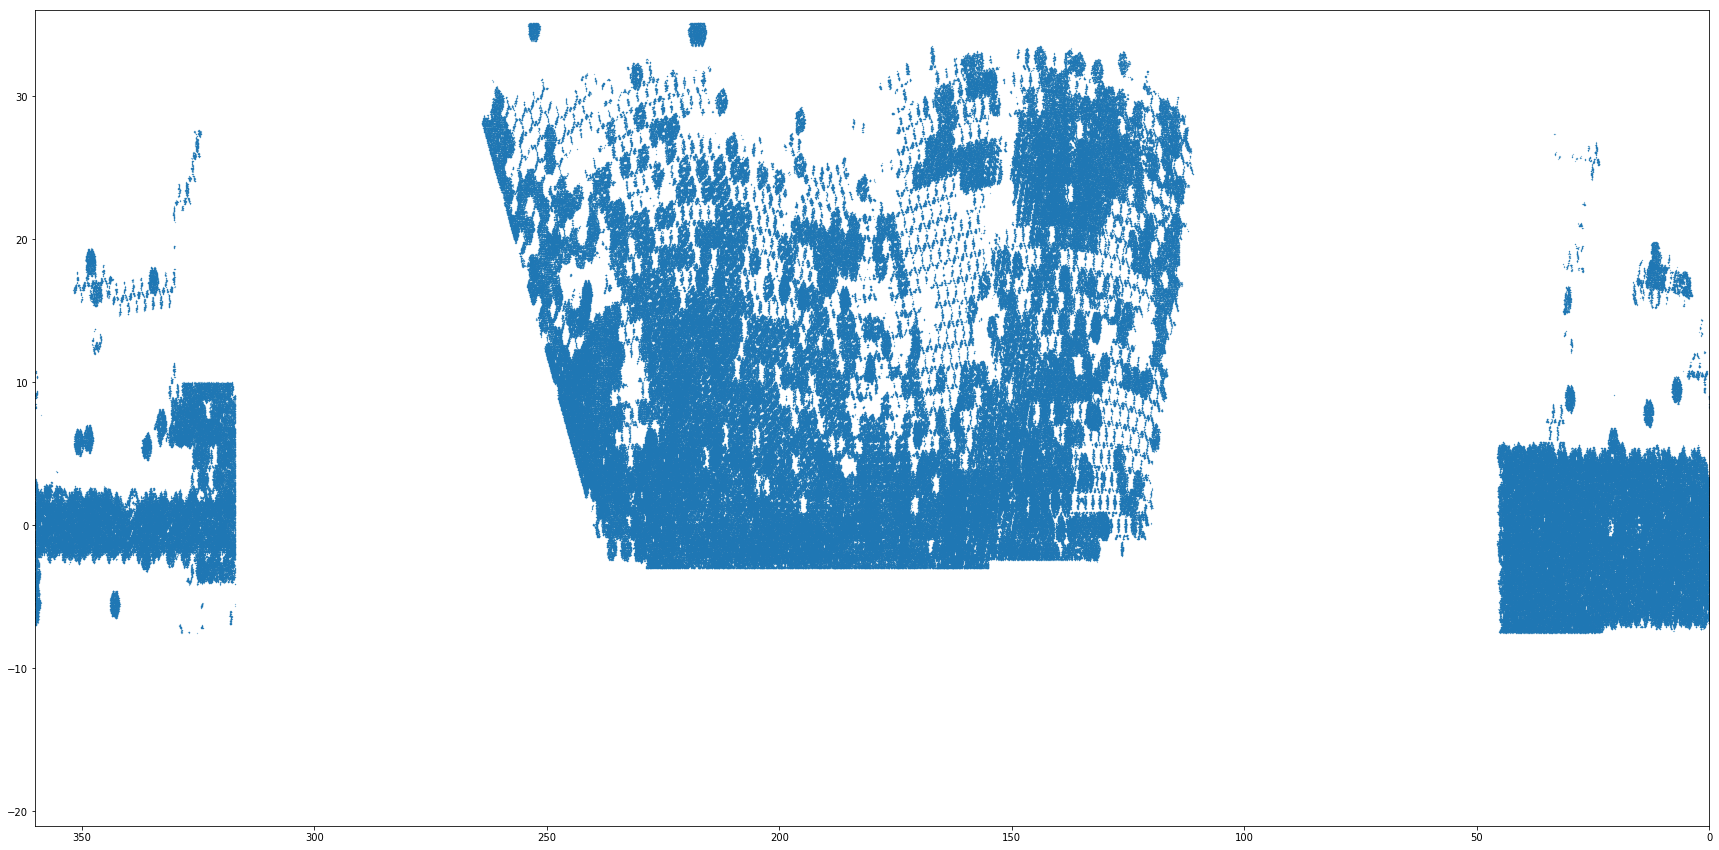

In [5]:
idx = np.random.choice(len(randoms), len(randoms)//10, replace=False)
plt.figure(figsize=(30, 15))
plt.plot(randoms['ra'][idx], randoms['dec'][idx], '.', markersize=0.4)
plt.axis([360, 0, -21, 36])
plt.show()

In [6]:
NSIDE = 2**7
npix = hp.nside2npix(NSIDE)
# hp.pixelfunc.ang2pix
ra_array, dec_array = hp.pixelfunc.pix2ang(NSIDE, np.arange(npix), lonlat=True)

pix = hp.pixelfunc.ang2pix(NSIDE, randoms['ra'], randoms['dec'], lonlat=True)
pix_unique, pix_count = np.unique(pix, return_counts=True)
m = np.zeros(npix)
m[pix_unique] = pix_count
# Convert to number density (per sq. deg.)
c = 1/(41253/npix)
m = m*c
occupied = m!=0
m_occupied = m[occupied]

ra_array = ra_array[occupied]
dec_array = dec_array[occupied]

__Remove boundary pixels__

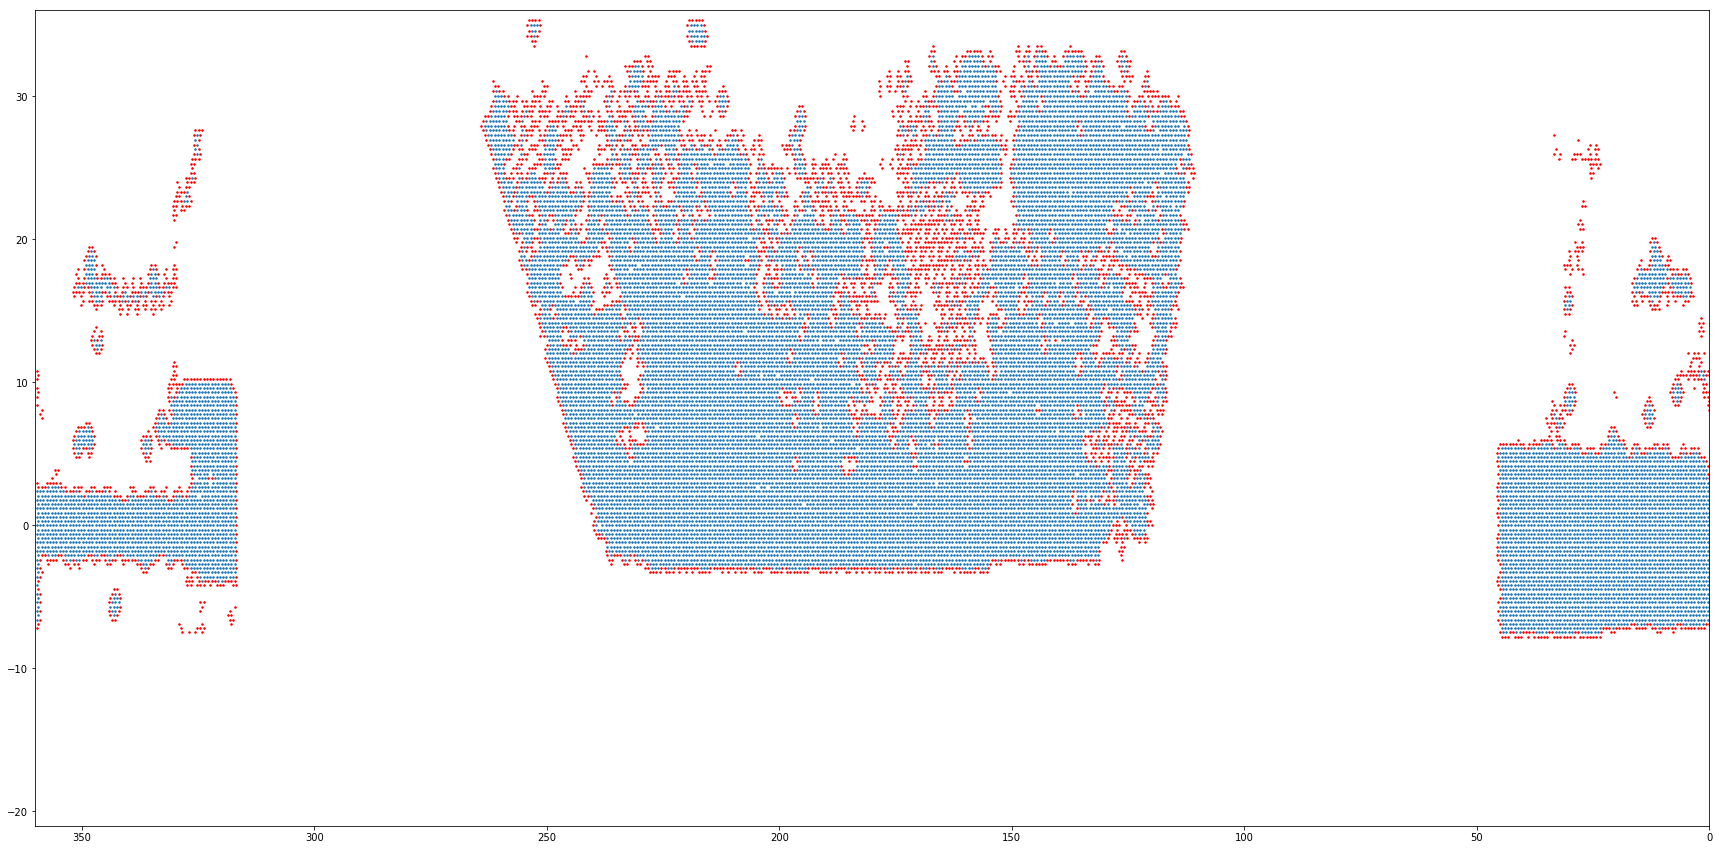

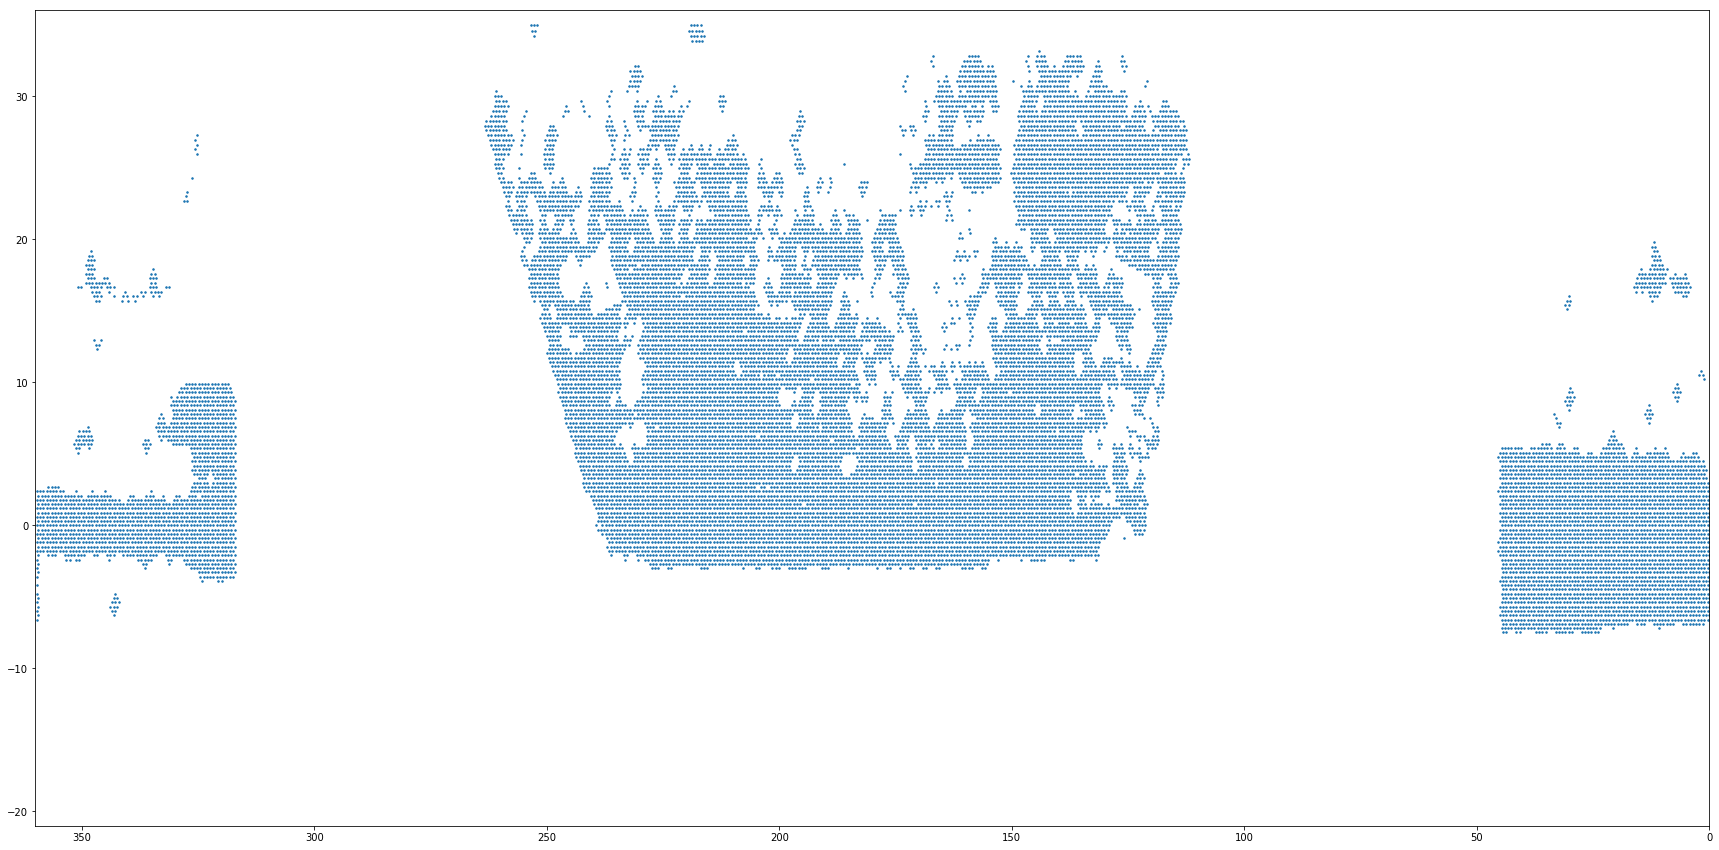

In [7]:
idx = pp_modules.find_survey_boundary(NSIDE, ra_array, dec_array, min_neighbors=min_neighbors)
hp_mask = np.ones(len(ra_array), dtype=bool)
hp_mask[idx] = False

plt.figure(figsize=(30, 15))
plt.plot(ra_array[hp_mask], dec_array[hp_mask], '.', markersize=3)
plt.plot(ra_array[~hp_mask], dec_array[~hp_mask], 'r.', markersize=3)
plt.axis([360, 0, -21, 36])
plt.show()

plt.figure(figsize=(30, 15))
plt.plot(ra_array[hp_mask], dec_array[hp_mask], '.', markersize=3)
plt.axis([360, 0, -21, 36])
plt.show()

23722 occupied heapix pixels
14701091 objects


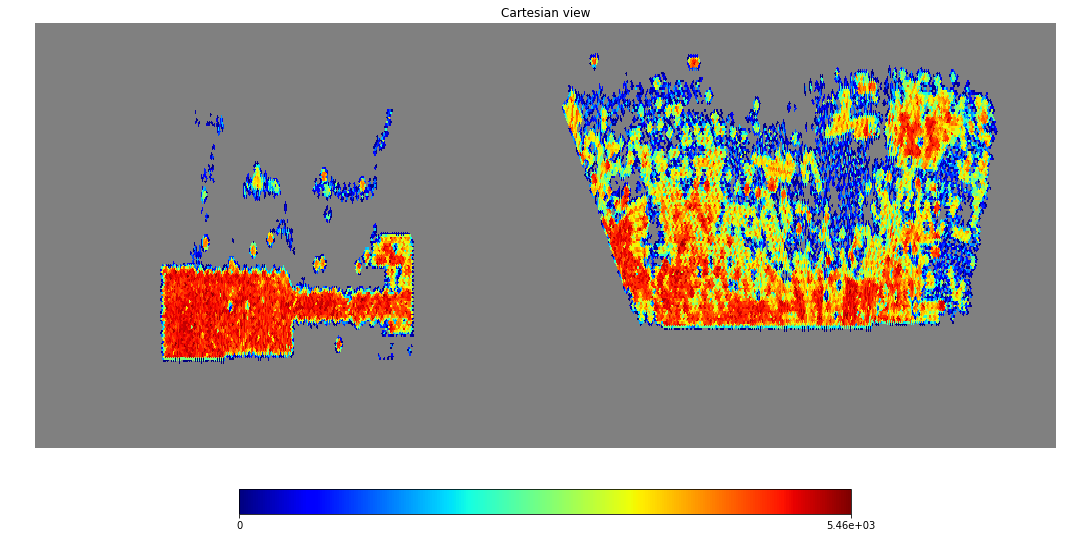

18864 (79.5%) heapix pixels after the cut
13869051 objects (94.3%)


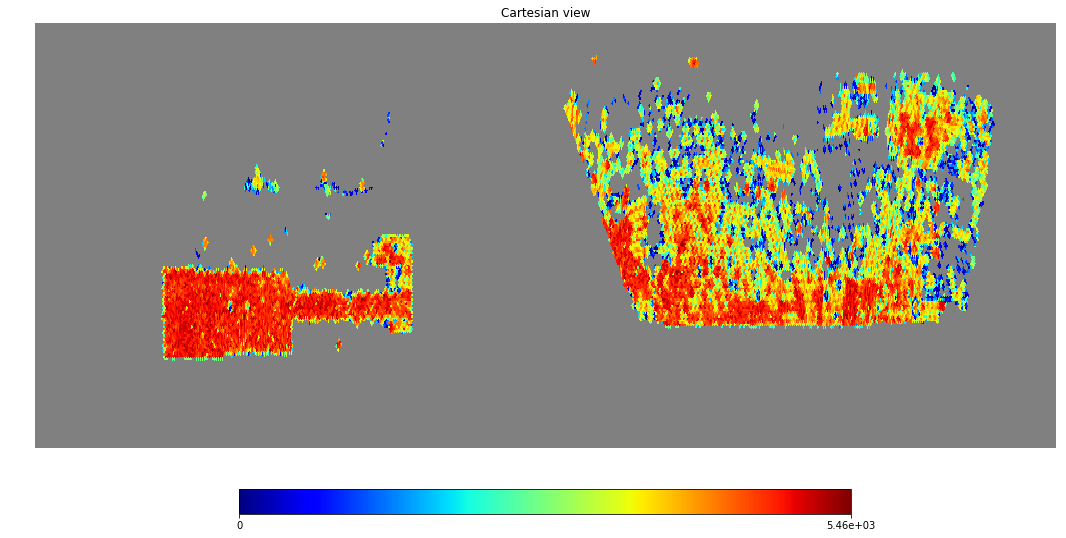

In [8]:
m_masked = hp.ma(m)
m_masked.mask = ~occupied

# plt.hist(m[occupied], 50)
# plt.show()

print(np.sum(occupied), 'occupied heapix pixels')
print(int(np.sum(m[occupied])/c), 'objects')

plt.rcParams['image.cmap'] = 'jet'
plt.figure(figsize=(20, 8))
hp.cartview(m_masked, min=0, rot=(-90, 0, 0), fig=1, latra=(-20, 40), aspect=2.5, xsize=2000)
plt.show()

nobj0 = int(np.sum(m_occupied)/c)
nobj = int(np.sum(m_occupied[hp_mask])/c)
m_final = m_occupied[hp_mask]

m_masked = hp.ma(m)
m_masked.mask = np.ones(len(m), dtype=bool)
m_masked.mask &= (~occupied)
m_masked.mask[occupied] = (~hp_mask)

print('{} ({:.1f}%) heapix pixels after the cut'
     .format(np.sum(hp_mask), np.sum(hp_mask)/np.sum(occupied)*100, ))
print('{} objects ({:.1f}%)'.format(nobj, nobj/nobj0*100))

plt.rcParams['image.cmap'] = 'jet'
plt.figure(figsize=(20, 8))
hp.cartview(m_masked, min=0, rot=(-90, 0, 0), fig=1, latra=(-20, 40), aspect=2.5, xsize=2000)
plt.show()

__Remove small islands__

In [9]:
# reload(pp_modules)

In [10]:
island_labels = pp_modules.identify_islands(NSIDE, ra_array[hp_mask], dec_array[hp_mask])

n_island = len(np.unique(island_labels))
island_sizes = np.zeros(np.sum(hp_mask))
for index in range(n_island):
    mask = island_labels == index
    island_sizes[mask] = np.sum(mask)    

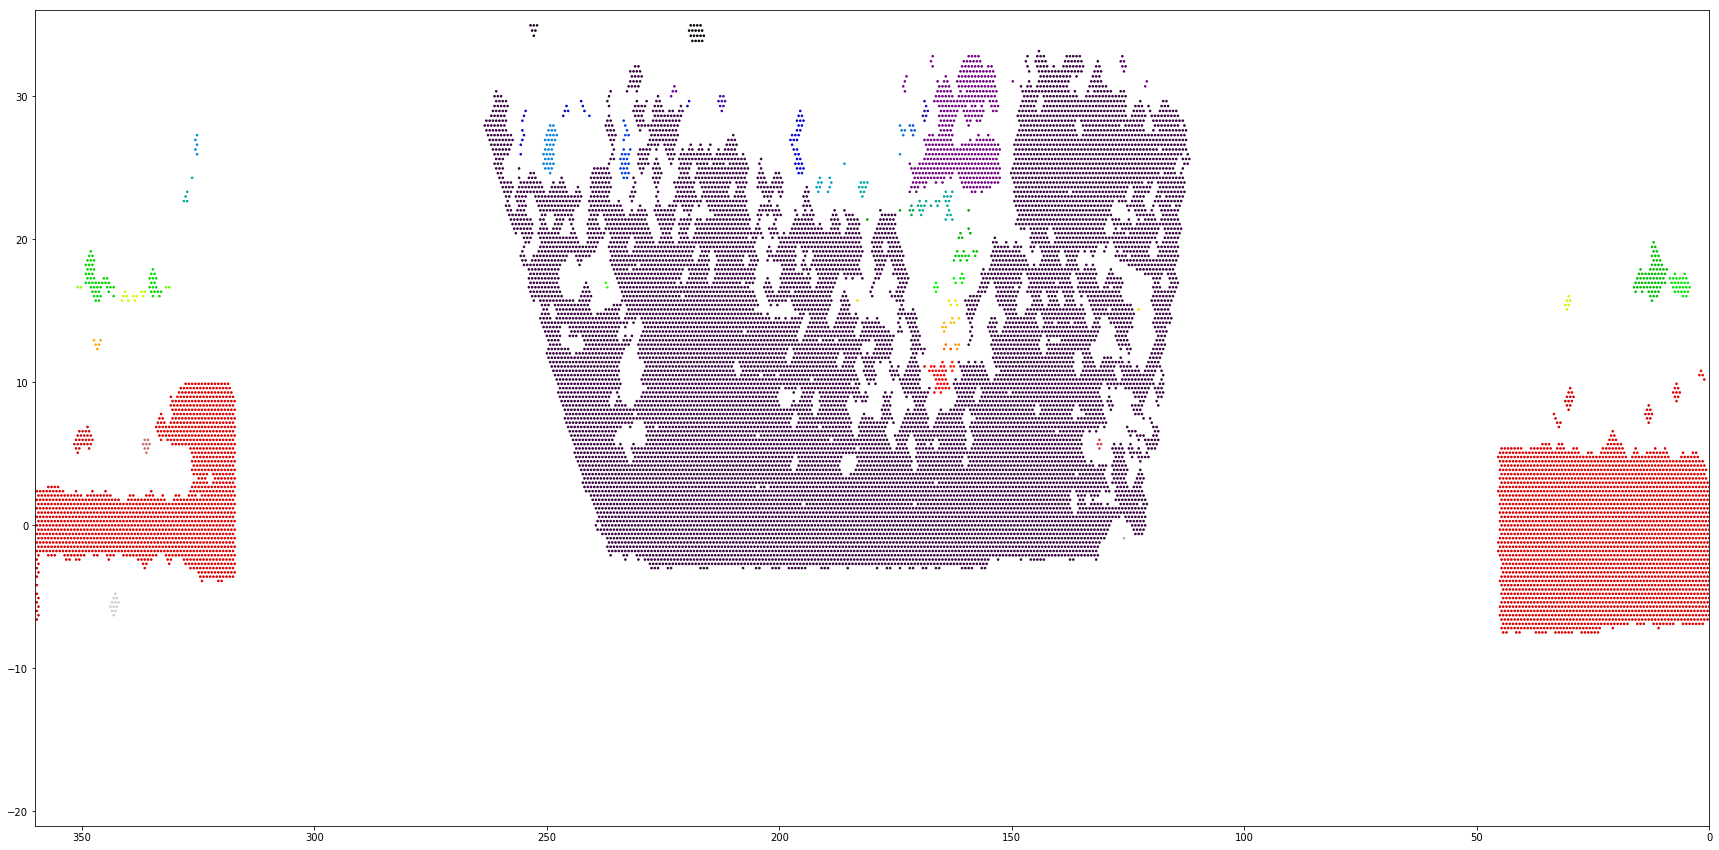

18266 (77.0%) heapix pixels after the cut
13593407 objects (92.5%)


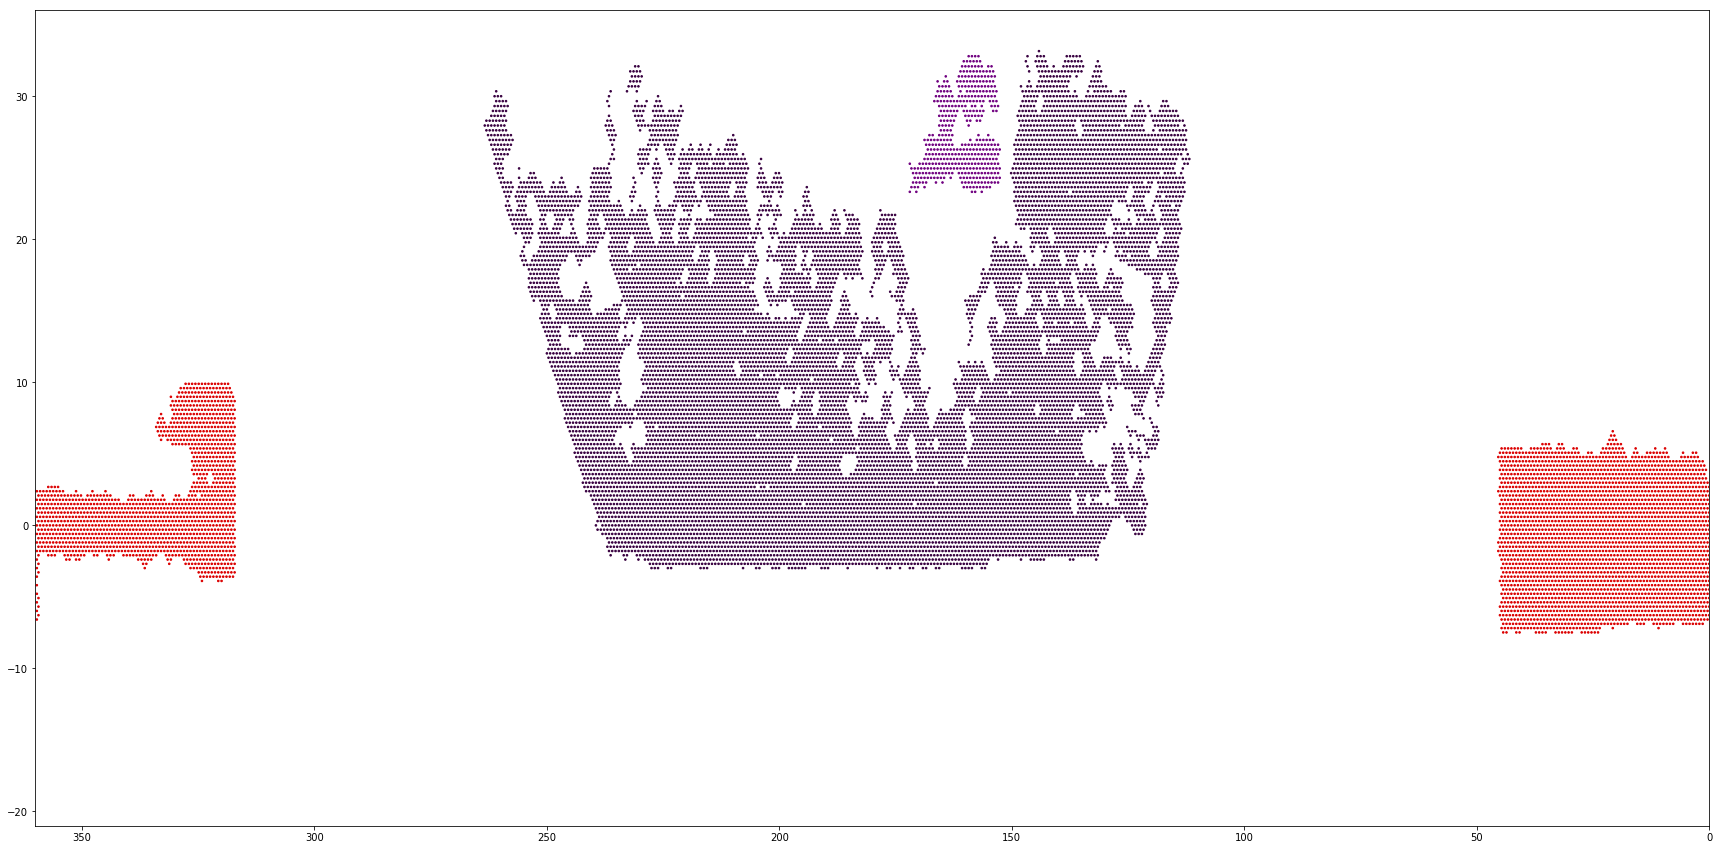

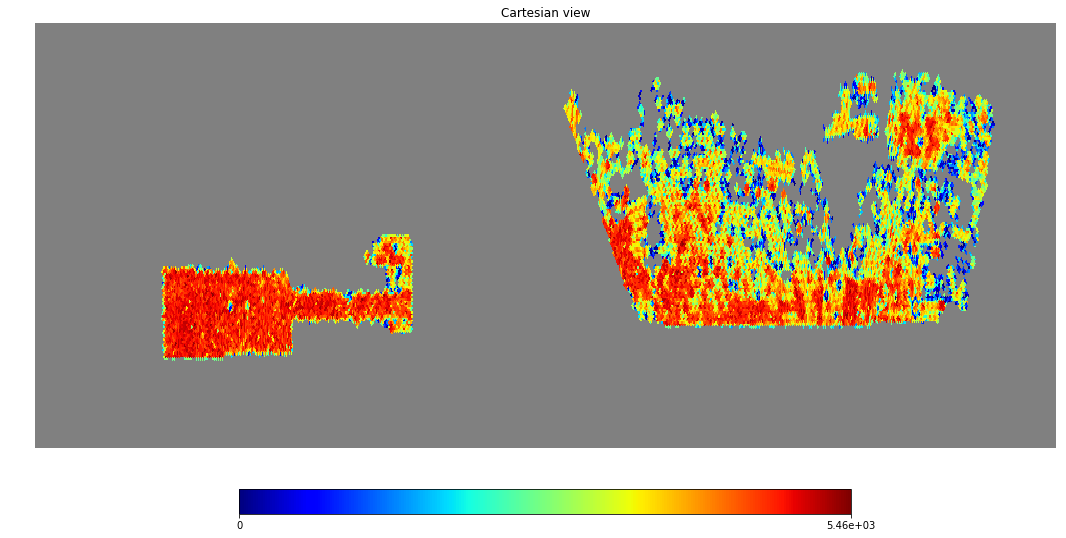

In [11]:
plt.figure(figsize=(30, 15))
plt.scatter(ra_array[hp_mask], dec_array[hp_mask], c=island_labels, edgecolor=None, cmap=plt.cm.spectral, s=2.5)
plt.axis([360, 0, -21, 36])
plt.show()

mask = island_sizes >= min_island_size
nobj = int(np.sum(m_occupied[hp_mask][mask])/c)

print('{} ({:.1f}%) heapix pixels after the cut'
     .format(np.sum(mask), np.sum(mask)/np.sum(occupied)*100, ))
print('{} objects ({:.1f}%)'.format(nobj, nobj/nobj0*100))

plt.figure(figsize=(30, 15))
plt.scatter(ra_array[hp_mask][mask], dec_array[hp_mask][mask], c=island_labels[mask], edgecolor=None, cmap=plt.cm.spectral, s=2.5, vmin=island_labels.min(), vmax=island_labels.max())
plt.axis([360, 0, -21, 36])
plt.show()

hp_mask1 = np.copy(hp_mask)
hp_mask1[hp_mask1] = mask
m_masked = hp.ma(m)
m_masked.mask = np.ones(len(m), dtype=bool)
m_masked.mask &= (~occupied)
m_masked.mask[occupied] = (~hp_mask1)

plt.rcParams['image.cmap'] = 'jet'
plt.figure(figsize=(20, 8))
hp.cartview(m_masked, min=0, rot=(-90, 0, 0), fig=1, latra=(-20, 40), aspect=2.5, xsize=2000)
plt.show()

__Add weights to pixels by generating more pixels at the same spot__

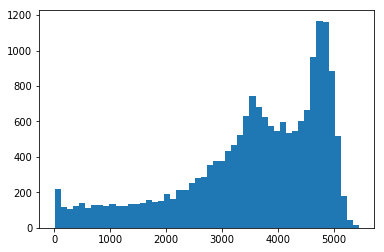

In [12]:
m_final = m_occupied[hp_mask1]
plt.hist(m_final, 50)
plt.show()

In [13]:
ra0 = ra_array[hp_mask1]
dec0 = dec_array[hp_mask1]

In [14]:
ra = np.copy(ra0)
dec = np.copy(dec0)
for i in range(1, 40):
    mask = np.round(m_final/250.)==i
    for j in range(i-1): # i-1 because there is already one copy
        ra = np.concatenate([ra, ra0[mask]])
        dec = np.concatenate([dec, dec0[mask]])

In [15]:
print(len(ra0))
print(len(ra))

18266
259271


In [52]:
######################################################
x = np.cos(dec/180.*np.pi) * np.cos(ra/180.*np.pi)
y = np.cos(dec/180.*np.pi) * np.sin(ra/180.*np.pi)
z = np.sin(dec/180.*np.pi)
######################################################

# ############### NOT WEIGHTED!!!! #####################
# x = np.cos(dec0/180.*np.pi) * np.cos(ra0/180.*np.pi)
# y = np.cos(dec0/180.*np.pi) * np.sin(ra0/180.*np.pi)
# z = np.sin(dec0/180.*np.pi)
# ######################################################

coords = np.column_stack([x, y, z])
print(len(coords))

259321


__Spherical K-means clustering:__

In [65]:
skmeans = SphericalKMeans(n_clusters=n_clusters, n_init=10, init='random')

t0 = time.time()
skmeans.fit(coords)
elapsed_time = time.time() - t0
print('time %.2fs'%(elapsed_time))

skm_labels = skmeans.labels_[:len(ra0)]

time 1329.23s


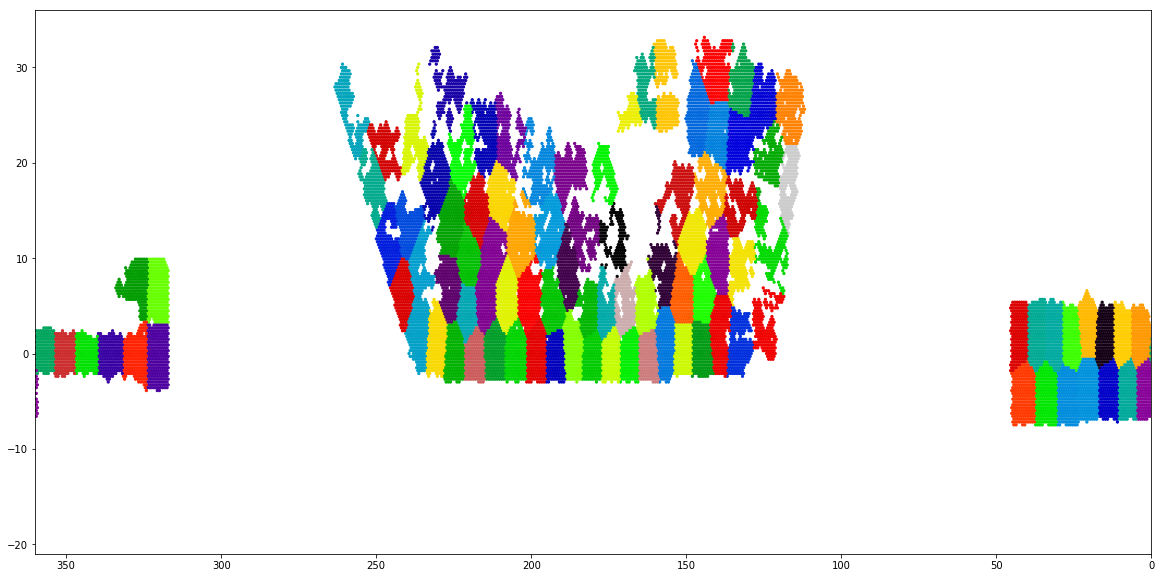

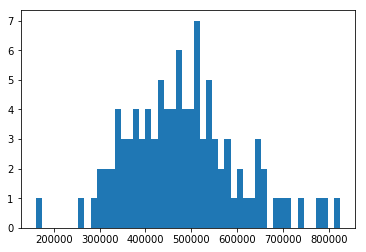

In [66]:
plt.figure(figsize=(20, 10))
plt.scatter(ra0, dec0, c=skm_labels,
            cmap=plt.cm.spectral, s=5)
plt.axis([360, 0, -21, 36])
plt.show()

skm_counts = np.zeros(n_clusters)
for idx_grp in range(n_clusters):
    members = np.where(skm_labels==idx_grp)[0]
    skm_counts[idx_grp] = np.sum(m_occupied[members])
plt.hist(skm_counts, 50)
plt.show()

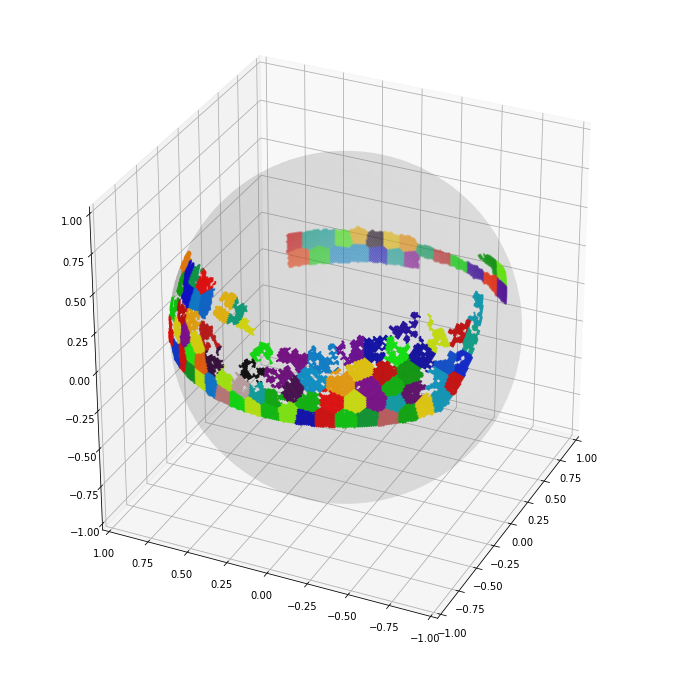

In [67]:
# 3D plot
from mpl_toolkits.mplot3d import Axes3D

u1 = np.linspace(0, 2 * np.pi, 200)
v1 = np.linspace(0, np.pi, 200)
x1 = 1 * np.outer(np.cos(u), np.sin(v))
y1 = 1 * np.outer(np.sin(u), np.sin(v))
z1 = 1 * np.outer(np.ones(np.size(u)), np.cos(v))

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal', projection='3d',
        adjustable='box-forced', xlim=[-1., 1.], ylim=[-1., 1.],
        zlim=[-1., 1.])
ax.plot_surface(x1, y1, z1,  rstride=4, cstride=4, color='gray', linewidth=0, alpha=0.1)
ax.scatter(x[:len(ra0)], y[:len(ra0)], z[:len(ra0)], 
           c=skm_labels, cmap=plt.cm.spectral, s=5, lw=0)
ax.set_aspect('equal')
ax.view_init(30, 205)
plt.show()

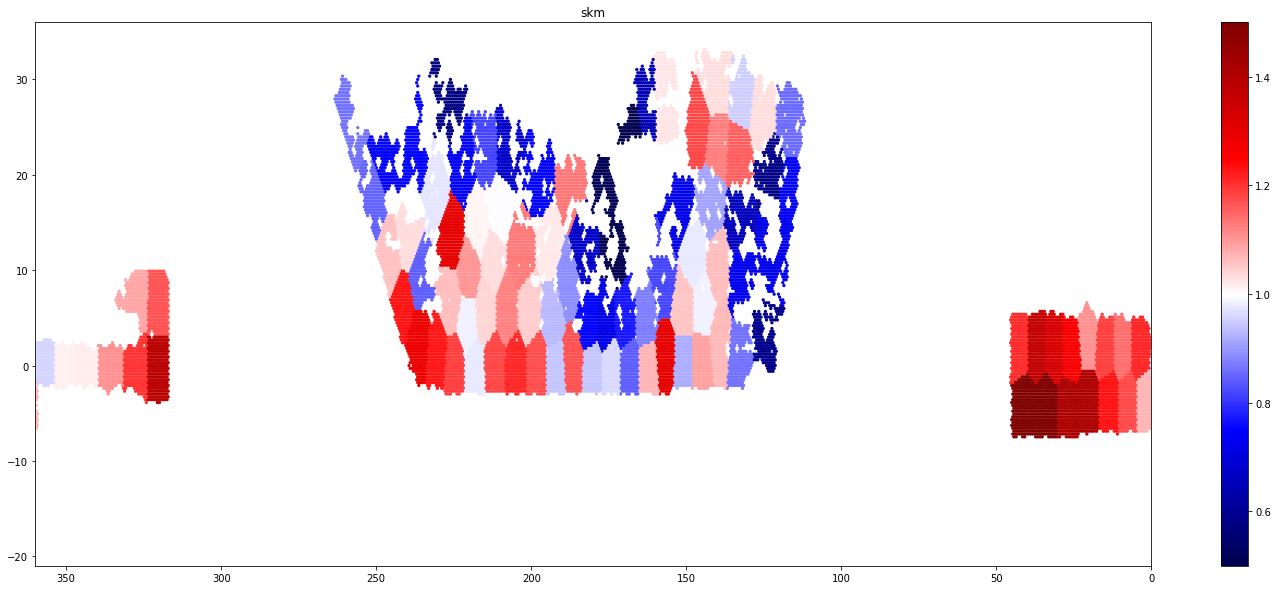

In [68]:
skm_group_counts = np.zeros(n_clusters)
average_count = np.sum(m_final/n_clusters)
for idx_grp in range(n_clusters):
    members = np.where(skm_labels==idx_grp)[0]
    skm_group_counts[idx_grp] = np.sum(m_final[members])
skm_counts_pix = skm_group_counts[skm_labels]
plt.figure(figsize=(25, 10))
plt.scatter(ra0, dec0, c=skm_counts_pix/average_count,
            cmap=plt.cm.seismic, s=5, vmin=0.5, vmax=1.5)
plt.colorbar()
plt.title('skm')
plt.axis([360, 0, -21, 36])
plt.show()

__Save clustering results__

In [37]:
t = Table()

# t['ra'] = ra1
# t['dec'] = dec1
# t['count'] = m_occupied1/c
# t['density'] = m_occupied1
t['ra'] = ra0
t['dec'] = dec0
t['count'] = m_final/c
t['density'] = m_final
t['label'] = skm_labels

t.write('/Users/roz18/git/desi-photoz/correlation/jackknife_partition/dr5/results/clustering_results1.txt', format='ascii.commented_header')